In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Fri Mar  8 09:41:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import numpy as np
import random
import pandas as pd
import os
import time
import librosa
import librosa.display
import IPython
from IPython.display import Audio
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
import sys

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

class FeatureEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv1d(1, 256, kernel_size=5, stride=1) # [batch size, 1, 193] -> [batch size, 256, 189]
        self.bn1 = nn.BatchNorm1d(256)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv1d(256, 128, kernel_size=5, stride=1) # [batch size, 256, 189] -> [batch size, 128, 185]
        self.bn2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.1)

        self.conv3 = nn.Conv1d(128, 128, kernel_size=5, stride=1) # [batch size, 128, 185] -> [batch size, 128, 181]
        self.bn3 = nn.BatchNorm1d(128)
        self.relu3 = nn.ReLU()

    def forward(self, x):
        # Convolutional layers
        conv_embedding = self.relu1(self.bn1(self.conv1(x)))
        conv_embedding = self.dropout1(self.relu2(self.bn2(self.conv2(conv_embedding))))
        conv_embedding = self.relu3(self.bn3(self.conv3(conv_embedding)))
        return conv_embedding

class EmotionClassifier(nn.Module):
    def __init__(self, num_emotions):
        super().__init__()

        self.conv4 = nn.Conv1d(128, 128, kernel_size=5, stride=1) # [batch size, 128, 181] -> [batch size, 128, 177]
        self.bn4 = nn.BatchNorm1d(128)
        self.relu4 = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=8) # [batch size, 128, 177] -> [batch size, 128, 22]

        self.conv5 = nn.Conv1d(128, 128, kernel_size=5, stride=1)
        self.bn5 = nn.BatchNorm1d(128)
        self.relu5 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)

        self.conv6 = nn.Conv1d(128, 128, kernel_size=5, stride=1)
        self.bn6 = nn.BatchNorm1d(128)
        self.relu6 = nn.ReLU()
        self.flatten = nn.Flatten()
        self.dropout3 = nn.Dropout(0.2)

        self.emotion_classifier = nn.Sequential(
            nn.Linear(1792, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, num_emotions),
        )

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Convolutional layers
        conv_embedding = self.maxpool(self.relu4(self.bn4(self.conv4(x))))
        conv_embedding = self.dropout2(self.relu5(self.bn5(self.conv5(conv_embedding))))
        conv_embedding = self.relu6(self.bn6(self.conv6(conv_embedding)))
        # Flatten
        conv_embedding = self.flatten(conv_embedding)
        conv_embedding = self.dropout3(conv_embedding)
        output_logits = self.emotion_classifier(conv_embedding)
        output_softmax = self.softmax(output_logits)

        return output_logits, output_softmax

class Critic(nn.Module): # Domain discriminator
    def __init__(self):
        super().__init__()

        self.conv4 = nn.Conv1d(128, 128, kernel_size=5, stride=1) # [batch size, 128, 181] -> [batch size, 128, 177]
        self.bn4 = nn.BatchNorm1d(128)
        self.relu4 = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=8) # [batch size, 128, 177] -> [batch size, 128, 22]

        self.conv5 = nn.Conv1d(128, 128, kernel_size=5, stride=1)
        self.bn5 = nn.BatchNorm1d(128)
        self.relu5 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)

        self.conv6 = nn.Conv1d(128, 128, kernel_size=5, stride=1)
        self.bn6 = nn.BatchNorm1d(128)
        self.relu6 = nn.ReLU()
        self.flatten = nn.Flatten()
        self.dropout3 = nn.Dropout(0.2)

        self.critic = nn.Sequential(
            nn.Linear(1792, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1),  # Linear activation for critic
            nn.Sigmoid() # between 0 and 1
        )

    def forward(self, x):
        conv_embedding = self.maxpool(self.relu4(self.bn4(self.conv4(x))))
        conv_embedding = self.dropout2(self.relu5(self.bn5(self.conv5(conv_embedding))))
        conv_embedding = self.relu6(self.bn6(self.conv6(conv_embedding)))
        # Flatten
        conv_embedding = self.flatten(conv_embedding)
        conv_embedding = self.dropout3(conv_embedding)
        return self.critic(conv_embedding)



In [5]:
# def invert_domain_labels(labels_tensor):
#     return -labels_tensor

In [6]:
import random

def invert_subset(labels_tensor, flip_prob):
    """
    Flip a random subset of numbers in a 1D tensor.

    Args:
    - tensor (torch.Tensor): Input 1D tensor containing only zeroes and ones.
    - flip_prob (float): Probability of flipping each element in the tensor.

    Returns:
    - torch.Tensor: Modified tensor with a random subset of elements flipped.
    """
    # Ensure the tensor contains only zeros and ones
    assert torch.all(torch.logical_or(labels_tensor == 0, labels_tensor == 1)), "Input tensor must contain only zeroes and ones."

    # Generate a mask for flipping elements based on flip_prob
    flip_mask = (torch.rand_like(labels_tensor) < flip_prob).float()

    # Flip the selected elements (0 becomes 1, and 1 becomes 0)
    flipped_tensor = torch.abs(labels_tensor - flip_mask)

    return flipped_tensor

In [7]:
X_train = np.load(file="/content/drive/MyDrive/FYP/4_TESS_DG_model/TESS+RAVDESS(30%)_TVT_5features/xtrain.npy")
X_test = np.load(file="/content/drive/MyDrive/FYP/4_TESS_DG_model/TESS+RAVDESS(30%)_TVT_5features/xtest.npy")
X_val = np.load(file="/content/drive/MyDrive/FYP/4_TESS_DG_model/TESS+RAVDESS(30%)_TVT_5features/xval.npy")

Y_train = np.load(file="/content/drive/MyDrive/FYP/4_TESS_DG_model/TESS+RAVDESS(30%)_TVT_5features/ytrain.npy")
Y_test = np.load(file="/content/drive/MyDrive/FYP/4_TESS_DG_model/TESS+RAVDESS(30%)_TVT_5features/ytest.npy")
Y_val = np.load(file="/content/drive/MyDrive/FYP/4_TESS_DG_model/TESS+RAVDESS(30%)_TVT_5features/yval.npy")

Z_train = np.load(file="/content/drive/MyDrive/FYP/4_TESS_DG_model/TESS+RAVDESS(30%)_TVT_5features/ztrain.npy")
Z_test = np.load(file="/content/drive/MyDrive/FYP/4_TESS_DG_model/TESS+RAVDESS(30%)_TVT_5features/ztest.npy")
Z_val = np.load(file="/content/drive/MyDrive/FYP/4_TESS_DG_model/TESS+RAVDESS(30%)_TVT_5features/zval.npy")

print(X_train.shape, Y_train.shape, Z_train.shape)
print(X_test.shape, Y_test.shape, Z_test.shape)
print(X_val.shape, Y_val.shape, Z_val.shape)
# random.shuffle(Y_train)
# random.shuffle(Y_train)
# random.shuffle(Y_train)
# random.shuffle(Y_train)

(7752, 1, 193) (7752,) (7752,)
(328, 1, 193) (328,) (328,)
(320, 1, 193) (320,) (320,)


In [8]:
# has_none = np.any(np.isnan(Y_train))
# if has_none:
#     print("The array contains at least one None value.")
# else:
#     print("The array does not contain None values.")

In [9]:
EMOTIONS = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 0:'surprise'}
EPOCHS = 250
DATASET_SIZE = X_train.shape[0]
BATCH_SIZE = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Selected device is {}'.format(device))

# Instantiate models
feature_encoder = FeatureEncoder().to(device)
emotion_classifier = EmotionClassifier(len(EMOTIONS)).to(device)
critic = Critic().to(device)

# model = EmotionCNN(num_emotions=len(EMOTIONS)).to(device)
# print('Number of trainable params: ', sum(p.numel() for p in model.parameters()))

# OPTIMIZER = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-5)
# OPTIMIZER = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-3, momentum=0.8)
# OPTIMIZER = torch.optim.SGD(model.parameters(), lr=0.0001, weight_decay=1e-5, momentum=0.8)
# OPTIMIZER = torch.optim.RMSprop(model.parameters(), lr=0.001, weight_decay=1e-5)
# OPTIMIZER = torch.optim.RMSprop(model.parameters(), lr=0.00001, weight_decay=1e-6)

# Define loss functions and optimizers
classification_loss_fn = nn.CrossEntropyLoss()
domain_discrimination_loss_fn = nn.BCELoss() # Binary loss when there are only 2 domains
feature_encoder_optimizer = optim.Adam(feature_encoder.parameters(), lr=0.0001, weight_decay=1e-5)
emotion_classifier_optimizer = optim.Adam(emotion_classifier.parameters(), lr=0.0001, weight_decay=1e-5)
critic_optimizer = optim.Adam(critic.parameters(), lr=0.0001, weight_decay=1e-5)


Selected device is cuda


In [10]:
training_classification_losses = []
training_domain_disc_losses = []

val_classification_losses = []
val_domain_disc_losses = []

start = time.time()

# Training loop
for epoch in range(EPOCHS):
    # shuffle data
    start_epoch = time.time()
    ind = np.random.permutation(DATASET_SIZE)
    X_train = X_train[ind,:,:]
    Y_train = Y_train[ind]
    Z_train = Z_train[ind]
    emotion_classification_acc = 0
    emotion_classification_loss = 0
    domain_disc_acc = 0
    epoch_domain_disc_loss = 0

    iters = int(DATASET_SIZE / BATCH_SIZE)

    feature_encoder.train()
    emotion_classifier.train()
    critic.train()

    for i in range(iters):

        ### ----- Setting up batch ----- ###
        batch_start = i * BATCH_SIZE
        batch_end = min(batch_start + BATCH_SIZE, DATASET_SIZE)
        actual_batch_size = batch_end-batch_start
        X = X_train[batch_start:batch_end,:,:]
        Y = Y_train[batch_start:batch_end]
        Z = Z_train[batch_start:batch_end]
        X_tensor = torch.tensor(X, device=device).float() # mel_spectrogram
        Y_tensor = torch.tensor(Y, dtype=torch.long, device=device) # emotion label
        Z_tensor = torch.tensor(Z, device=device).float() # domain label

        ### ----- Training step ----- ###
        # Forward pass
        features = feature_encoder(X_tensor)
        emotion_logits, emotion_softmax = emotion_classifier(features.detach()) # [64, 8] , .detach() creates a copy of the tensor that does not require gradients
                                                                                # This DOES NOT change the requires_grad attribute of the original tensor or parameters of the model
                                                                                # logits are used for cross entropy loss
                                                                                # softmax used for actual prediction (0-7)

        domain_predictions = critic(features.detach())
        domain_predictions_squeezed = domain_predictions.squeeze(dim=1).clone() # [64, 1] to [64] , .clone() to prevent in-place operations
        domain_predictions2 = critic(features) # feature encoder adversarial training
        domain_predictions2_squeezed = domain_predictions2.squeeze(dim=1).clone()

        # Compute losses
        classification_loss = classification_loss_fn(emotion_logits, Y_tensor) # Y_tensor.shape [64]
        domain_discrimination_loss = domain_discrimination_loss_fn(domain_predictions_squeezed, Z_tensor)

        # Backpropagation and optimization for domain discriminator (critic)
        domain_discrimination_loss.backward() # critic only
        # critic_optimizer.step()
        # critic_optimizer.zero_grad()

        # Backpropagation and optimization for emotion classifier
        classification_loss.backward() # emotion classifier only
        emotion_classifier_optimizer.step()
        emotion_classifier_optimizer.zero_grad()

        # Adversarial training for feature extractor (Inverting domain labels to fool the discriminator)
        invert_prob = 0.7 # probability of flipping
        inverted_domain_labels = invert_subset(Z_tensor, invert_prob)
        adversarial_loss = domain_discrimination_loss_fn(domain_predictions2_squeezed, inverted_domain_labels)
        adversarial_loss.backward() # critic + feature encoder
        feature_encoder_optimizer.step()
        feature_encoder_optimizer.zero_grad()

        ### ----- Tracking training loss per epoch ----- ###
        # Emotion classification
        actual_prediction = torch.argmax(emotion_softmax, dim=1) # Actual prediction (0-7)
        prediction_accuracy = (torch.sum(Y_tensor == actual_prediction)/float(len(Y_tensor))) * 100
        emotion_classification_acc += prediction_accuracy*actual_batch_size/DATASET_SIZE
        emotion_classification_loss += classification_loss*actual_batch_size/DATASET_SIZE

        # Domain discrimination
        predicted_domain_labels = (domain_predictions_squeezed > 0.5).long()
        correct_domain_predictions = (predicted_domain_labels == Z_tensor.long()).float()
        batch_domain_disc_acc = (torch.sum(correct_domain_predictions) / len(Z_tensor)) * 100
        domain_disc_acc += batch_domain_disc_acc*actual_batch_size/DATASET_SIZE
        epoch_domain_disc_loss += domain_discrimination_loss*actual_batch_size/DATASET_SIZE
        print(f"\r Epoch {epoch}: iteration {i}/{iters}",end='')

        # break

    ### ----- Validation step ----- ###
    X_val_tensor = torch.tensor(X_val, device=device).float()
    Y_val_tensor = torch.tensor(Y_val, dtype=torch.long, device=device)
    Z_val_tensor = torch.tensor(Z_val, device=device).float()

    feature_encoder.eval()
    emotion_classifier.eval()
    critic.eval()

    with torch.no_grad():
        features = feature_encoder(X_val_tensor)
        emotion_logits, emotion_softmax = emotion_classifier(features)
        domain_predictions = critic(features)
        domain_predictions_squeezed = domain_predictions.squeeze(dim=1).clone()

        val_classification_loss = classification_loss_fn(emotion_logits, Y_val_tensor)
        val_domain_discrimination_loss = domain_discrimination_loss_fn(domain_predictions_squeezed, Z_val_tensor)

        ### ----- Tracking validation loss per epoch ----- ###
        # Validation emotion classification
        actual_prediction = torch.argmax(emotion_softmax, dim=1)
        val_prediction_acc = (torch.sum(Y_val_tensor == actual_prediction)/float(len(Y_val_tensor))) * 100

        # Validation domain discrimination
        predicted_domain_labels = (domain_predictions_squeezed > 0.5).long()
        correct_domain_predictions = (predicted_domain_labels == Z_val_tensor.long()).float()
        val_domain_disc_acc = (torch.sum(correct_domain_predictions) / len(Z_val_tensor)) * 100

    ### ----- Tracking loss over time to graph ----- ###
    training_classification_losses.append(emotion_classification_loss.cpu())
    training_domain_disc_losses.append(epoch_domain_disc_loss)
    val_classification_losses.append(val_classification_loss.cpu())
    val_domain_disc_losses.append(val_domain_discrimination_loss)
    elapsed_epoch = time.time() - start_epoch
    print('')
    print(f" Epoch {epoch} --> Emotion classification acc: {emotion_classification_acc:.2f}%, Emotion classification loss: {emotion_classification_loss:.4f}, \
             Domain prediction acc: {domain_disc_acc:.2f}%, Domain discrimination loss: {epoch_domain_disc_loss:.4f}, \n\
             Val classification acc: {val_prediction_acc:.4f}%, Val classification loss: {val_classification_loss:.2f}, \
             \t    Val domain acc: {val_domain_disc_acc:.4f}%, Val domain loss: {val_domain_discrimination_loss:.2f}, \
             \t time:{elapsed_epoch:.2f}sec \n")
    # break


 Epoch 0: iteration 120/121
 Epoch 0 --> Emotion classification acc: 26.21%, Emotion classification loss: 1.8087,              Domain prediction acc: 35.66%, Domain discrimination loss: 0.7051, 
             Val classification acc: 46.2500%, Val classification loss: 1.61,              	    Val domain acc: 21.8750%, Val domain loss: 0.72,              	 time:4.02sec 

 Epoch 1: iteration 120/121
 Epoch 1 --> Emotion classification acc: 42.85%, Emotion classification loss: 1.4426,              Domain prediction acc: 8.04%, Domain discrimination loss: 0.7451, 
             Val classification acc: 59.6875%, Val classification loss: 1.08,              	    Val domain acc: 5.3125%, Val domain loss: 0.75,              	 time:2.08sec 

 Epoch 2: iteration 120/121
 Epoch 2 --> Emotion classification acc: 50.86%, Emotion classification loss: 1.2253,              Domain prediction acc: 3.33%, Domain discrimination loss: 0.7705, 
             Val classification acc: 70.0000%, Val classification lo

In [11]:
elapsed = time.time() - start
print(f"Total training time:{elapsed:.2f}sec")

Total training time:614.40sec


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

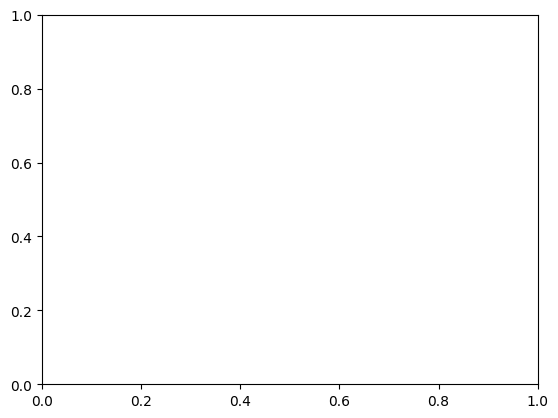

In [ ]:
plt.plot(training_classification_losses,'b')
plt.plot(val_classification_losses,'r')
plt.legend(['train loss','val loss'])

In [12]:
SAVE_PATH = os.path.join(os.getcwd(),'/content/drive/MyDrive/FYP/4_TESS_DG_model/5f ADDoG model TESS+RAVDESS(30%)')
# os.makedirs('models',exist_ok=True)
torch.save(feature_encoder.state_dict(),os.path.join(SAVE_PATH,'feature_encoder.pt'))
torch.save(emotion_classifier.state_dict(),os.path.join(SAVE_PATH,'emotion_classifier.pt'))
torch.save(critic.state_dict(),os.path.join(SAVE_PATH,'critic.pt'))
print('Models are saved to {}'.format(os.path.join(SAVE_PATH,'feature_encoder.pt')))
print('Models are saved to {}'.format(os.path.join(SAVE_PATH,'emotion_classifier.pt')))
print('Models are saved to {}'.format(os.path.join(SAVE_PATH,'critic.pt')))

Models are saved to /content/drive/MyDrive/FYP/4_TESS_DG_model/5f ADDoG model TESS+RAVDESS(30%)/feature_encoder.pt
Models are saved to /content/drive/MyDrive/FYP/4_TESS_DG_model/5f ADDoG model TESS+RAVDESS(30%)/emotion_classifier.pt
Models are saved to /content/drive/MyDrive/FYP/4_TESS_DG_model/5f ADDoG model TESS+RAVDESS(30%)/critic.pt


In [13]:
# Load models
LOAD_PATH = os.path.join(os.getcwd(),'/content/drive/MyDrive/FYP/4_TESS_DG_model/5f ADDoG model TESS+RAVDESS(30%)')

feature_encoder.load_state_dict(torch.load(os.path.join(LOAD_PATH,'feature_encoder.pt')))
print('Feature encoder is loaded from {}'.format(os.path.join(LOAD_PATH,'feature_encoder.pt')))

emotion_classifier.load_state_dict(torch.load(os.path.join(LOAD_PATH,'emotion_classifier.pt')))
print('Emotion classifier is loaded from {}'.format(os.path.join(LOAD_PATH,'emotion_classifier.pt')))

critic.load_state_dict(torch.load(os.path.join(LOAD_PATH,'critic.pt')))
print('Critic is loaded from {}'.format(os.path.join(LOAD_PATH,'critic.pt')))

Feature encoder is loaded from /content/drive/MyDrive/FYP/4_TESS_DG_model/5f ADDoG model TESS+RAVDESS(30%)/feature_encoder.pt
Emotion classifier is loaded from /content/drive/MyDrive/FYP/4_TESS_DG_model/5f ADDoG model TESS+RAVDESS(30%)/emotion_classifier.pt
Critic is loaded from /content/drive/MyDrive/FYP/4_TESS_DG_model/5f ADDoG model TESS+RAVDESS(30%)/critic.pt


In [14]:
Ravdess_X_test = np.load(file="/content/drive/MyDrive/FYP/4_TESS_DG_model/TESS+RAVDESS(30%)_TVT_5features/Ravdess_xtest.npy")
Ravdess_Y_test = np.load(file="/content/drive/MyDrive/FYP/4_TESS_DG_model/TESS+RAVDESS(30%)_TVT_5features/Ravdess_ytest.npy")
Ravdess_Z_test = np.load(file="/content/drive/MyDrive/FYP/4_TESS_DG_model/TESS+RAVDESS(30%)_TVT_5features/Ravdess_ztest.npy")

print(Ravdess_X_test.shape)
print(Ravdess_Y_test.shape)
print(Ravdess_Z_test.shape)

(1008, 1, 193)
(1008,)
(1008,)


In [15]:
start = time.time()

X_test_tensor = torch.tensor(Ravdess_X_test, device=device).float()
Y_test_tensor = torch.tensor(Ravdess_Y_test, dtype=torch.long, device=device)
Z_test_tensor = torch.tensor(Ravdess_Z_test, device=device).float()

feature_encoder.eval()
emotion_classifier.eval()
critic.eval()

with torch.no_grad():
    features = feature_encoder(X_test_tensor)
    emotion_logits, emotion_softmax = emotion_classifier(features)
    domain_predictions = critic(features)
    domain_predictions_squeezed = domain_predictions.squeeze(dim=1).clone()

    val_classification_loss = classification_loss_fn(emotion_logits, Y_test_tensor)
    val_domain_discrimination_loss = domain_discrimination_loss_fn(domain_predictions_squeezed, Z_test_tensor)

    ### ----- Tracking validation loss per epoch ----- ###
    # Validation emotion classification
    actual_prediction = torch.argmax(emotion_softmax, dim=1)
    val_prediction_acc = (torch.sum(Y_test_tensor == actual_prediction)/float(len(Y_test_tensor))) * 100

    # Validation domain discrimination
    predicted_domain_labels = (domain_predictions_squeezed > 0.5).long()
    correct_domain_predictions = (predicted_domain_labels == Z_test_tensor.long()).float()
    val_domain_disc_acc = (torch.sum(correct_domain_predictions) / len(Z_test_tensor)) * 100

elapsed = time.time() - start
print(f"Total test time:{elapsed:.3f}sec")
print(f'Emotion classification Test loss is {val_classification_loss:.3f}')
print(f'Emotion classification Test accuracy is {val_prediction_acc:.2f}%')

Total test time:0.080sec
Emotion classification Test loss is 2.725
Emotion classification Test accuracy is 54.07%


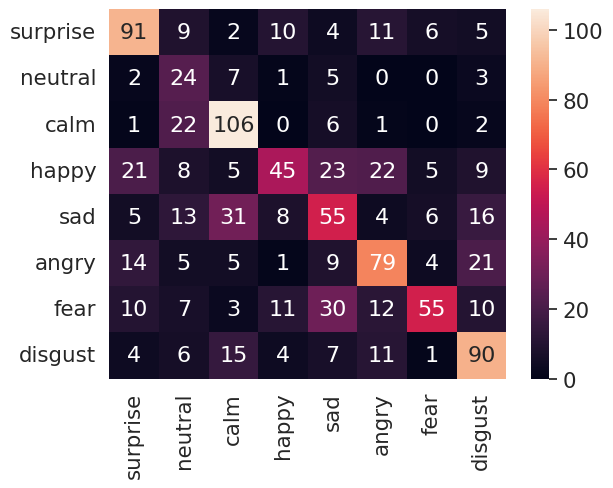

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

actual_prediction = actual_prediction.cpu().numpy()
cm = confusion_matrix(Ravdess_Y_test, actual_prediction)
names = [EMOTIONS[ind] for ind in range(len(EMOTIONS))]
df_cm = pd.DataFrame(cm, index=names, columns=names)
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size
plt.show()

# Rows are the inputs, columns are the classification